In [1]:
from keras.applications.convnext import LayerScale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from classification_metrics import print_confidence_intervals, get_performance_metrics, bootstrap_auc, plot_calibration_curve, roc_auc_score, get_accuracy, get_prevalence, get_sensitivity, get_specificity, get_ppv, get_npv 
from data_preparation import prepare_data
from model_preprocessing import model_predict

In [2]:
TARGET_HEIGHT = 640
TARGET_WIDTH = 640

## Load data

In [3]:
X_val, y_val, valid_labels_df, targets = prepare_data()

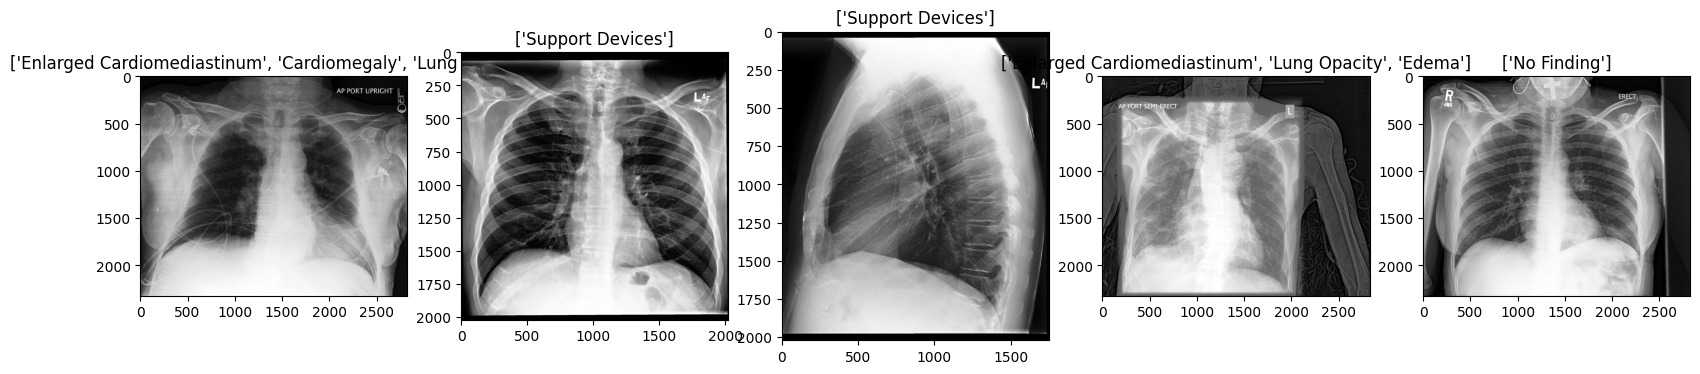

In [4]:
#get the first 5 images
paths =  valid_labels_df.path[:5]
labels = valid_labels_df.feature_string[:5]

fig, m_axs = plt.subplots(1, len(labels), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(np.asarray(Image.open(paths[ii])), cmap='gray')
    c_ax.set_title(labels[ii])
plt.show()

## Load model

In [22]:
# List all models
!ls ../models

model_ConvNeXtBase_w_ClssWgt_03-0.3726.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3616.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3887.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.4021.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.4813.h5
pretrain_model_ConvNeXtBase_w_ClssWgt_02-0.4721.h5
pretrain_model_ConvNeXtSmall_w_ClssWgt_02-0.4580.h5
pretrain_model_ConvNeXtSmall_w_ClssWgt_03-0.5216.h5


In [38]:
MODEL_NAME = 'pretrain_model_ConvNeXtSmall_w_ClssWgt_03-0.5216.h5'
model_path = f'../models/{MODEL_NAME}'
model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

In [39]:
model.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageInput (InputLayer)        [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_stem (Sequential  (None, 160, 160, 12  6528       ['ImageInput[0][0]']             
 )                              8)                                                                
                                                                                                  
 convnext_base_stage_0_block_0_  (None, 160, 160, 12  6400       ['convnext_base_stem[0][0]']     
 depthwise_conv (Conv2D)        8)                                                         

                                                                                                  
 convnext_base_downsampling_blo  (None, 80, 80, 256)  131584     ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 80, 80, 256)  12800      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 80, 80, 256)  512        ['convnext_base_stage_1_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_

 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  25600      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_0_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_0_p
 gelu (Act

 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_3_p
 gelu (Activation)              )                                ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_3_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
          

 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_11[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_6_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_

                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  25600      ['tf.__operators__.add_15[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_10_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_10_
 _pointwis

 convnext_base_stage_2_block_13  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_13_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_13_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_13_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_

 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_16_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_16_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_16_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
          

 convnext_base_stage_2_block_19  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_19_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_19_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_19_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_25 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_24[0][0]',
 ambda)   

                                                                                                  
 convnext_base_stage_2_block_22  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_22_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_28 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_27[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_22_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_23  (None, 40, 40, 512)  25600      ['tf.__operators__.add_28[0][0]']
 _depthwise_conv (Conv2D)                                                                         
          

 ambda)                                                           'convnext_base_stage_2_block_25_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  25600      ['tf.__operators__.add_31[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_26_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_

 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  51200      ['tf.__operators__.add_34[0][0]']
 depthwise_conv (Conv2D)        )                                                                 
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  2048       ['convnext_base_stage_3_block_2_d
 layernorm (LayerNormalization)  )                               epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 4096  4198400    ['convnext_base_stage_3_block_2_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 4096  0          ['convnext_base_stage_3_block_2_p
 gelu (Act

## Store predictions

Store all predictions in a dataframe

CAUTION! Make sure the preprocessing matches what was used during model training 

In [41]:
pred_columns = [col_name + '_pred' for col_name in targets]
target_columns = [col_name + '_label' for col_name in targets]

In [42]:
all_model_preds = pd.DataFrame(0, index=np.arange(len(X_val)), columns=pred_columns)

In [43]:
for i, path in enumerate(X_val):
    if i % 10 == 0:
        print(f'{i} out of {len(X_val)}')
    all_model_preds.iloc[i, :] = model_predict(path=path, model=model, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)[0]

0 out of 234
1/1 [==============================] - 0s 64ms/step
10 out of 234
1/1 [==============================] - 0s 64ms/step
20 out of 234
1/1 [==============================] - 0s 65ms/step
30 out of 234
1/1 [==============================] - 0s 65ms/step
40 out of 234
1/1 [==============================] - 0s 65ms/step
50 out of 234
1/1 [==============================] - 0s 64ms/step
60 out of 234
1/1 [==============================] - 0s 65ms/step
70 out of 234
1/1 [==============================] - 0s 65ms/step
80 out of 234
1/1 [==============================] - 0s 63ms/step
90 out of 234
1/1 [==============================] - 0s 60ms/step
100 out of 234
1/1 [==============================] - 0s 64ms/step
110 out of 234
1/1 [==============================] - 0s 60ms/step
120 out of 234
1/1 [==============================] - 0s 65ms/step
130 out of 234
1/1 [==============================] - 0s 61ms/step
140 out of 234
1/1 [==============================] - 0s 65ms/step
150 ou

1/1 [==============================] - 0s 64ms/step
160 out of 234
1/1 [==============================] - 0s 64ms/step
170 out of 234
1/1 [==============================] - 0s 64ms/step
180 out of 234
1/1 [==============================] - 0s 65ms/step
190 out of 234
1/1 [==============================] - 0s 64ms/step
200 out of 234
1/1 [==============================] - 0s 63ms/step
210 out of 234
1/1 [==============================] - 0s 65ms/step
220 out of 234
1/1 [==============================] - 0s 60ms/step
230 out of 234
1/1 [==============================] - 0s 64ms/step


In [44]:
all_model_preds.head()

,No Finding_u_zero_pred,Enlarged Cardiomediastinum_u_zero_pred,Cardiomegaly_u_zero_pred,Lung Opacity_u_zero_pred,Lung Lesion_u_zero_pred,Edema_u_zero_pred,Consolidation_u_zero_pred,Pneumonia_u_zero_pred,Atelectasis_u_zero_pred,Pneumothorax_u_zero_pred,Pleural Effusion_u_zero_pred,Pleural Other_u_zero_pred,Fracture_u_zero_pred,Support Devices_u_zero_pred
0,0.055238,0.018921,0.042216,0.316749,0.121619,0.002129,0.006480,0.009268,0.041685,0.009167,0.000943,0.003824,0.004925,0.009630
1,0.505327,0.014038,0.001224,0.007824,0.478378,0.000002,0.000993,0.000935,0.005174,0.000705,0.002431,0.013111,0.002016,0.982793
2,0.512122,0.020383,0.029399,0.005227,0.068132,0.000128,0.001381,0.001377,0.000880,0.003717,0.010465,0.002418,0.024962,0.733865
3,0.000095,0.128174,0.001801,0.573638,0.340870,0.000964,0.014998,0.011296,0.012672,0.029062,0.001194,0.034619,0.107162,0.000443
4,0.598029,0.003461,0.001041,0.190029,0.329730,0.000453,0.053922,0.110747,0.002701,0.061627,0.000810,0.026325,0.004643,0.088068


In [45]:
results = pd.DataFrame(data=y_val, columns=target_columns)
results = pd.concat([results, all_model_preds], axis=1)

In [46]:
y = results[target_columns].values
pred = results[pred_columns].values

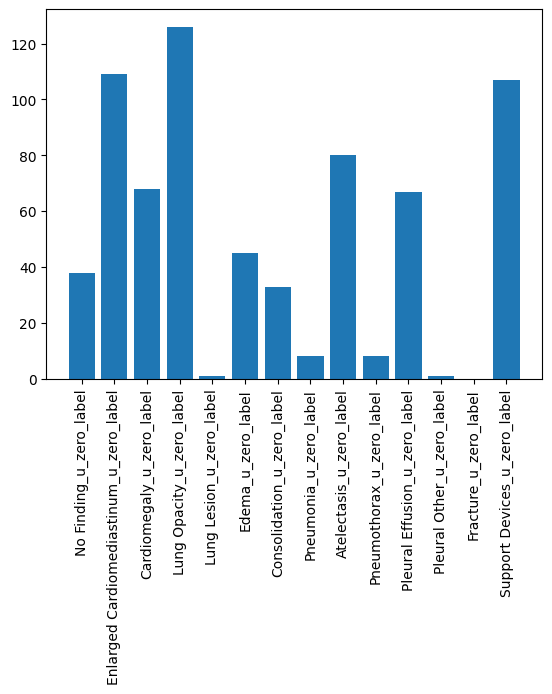

In [47]:
plt.xticks(rotation=90)
plt.bar(x = target_columns, height= y.sum(axis=0))
plt.show()

## Calculate metrics

In [48]:
get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score, f1=f1_score)

Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuou

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
No Finding_u_zero_label,16,175,21,22,0.816,0.162,0.421,0.893,0.432,0.888,0.838,NaN,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,0.534,0.466,0.0,1.0,0.0,0.534,0.616,NaN,0.5
Cardiomegaly_u_zero_label,15,163,3,53,0.761,0.291,0.221,0.982,0.833,0.755,0.725,NaN,0.5
Lung Opacity_u_zero_label,88,100,8,38,0.803,0.538,0.698,0.926,0.917,0.725,0.868,NaN,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,0.0,1.0,0.0,0.996,0.348,NaN,0.5
Edema_u_zero_label,15,182,7,30,0.842,0.192,0.333,0.963,0.682,0.858,0.874,NaN,0.5
Consolidation_u_zero_label,2,198,3,31,0.855,0.141,0.061,0.985,0.4,0.865,0.803,NaN,0.5
Pneumonia_u_zero_label,0,225,1,8,0.962,0.034,0.0,0.996,0.0,0.966,0.415,NaN,0.5
Atelectasis_u_zero_label,11,151,3,69,0.692,0.342,0.138,0.981,0.786,0.686,0.813,NaN,0.5
Pneumothorax_u_zero_label,5,218,8,3,0.953,0.034,0.625,0.965,0.385,0.986,0.773,NaN,0.5


In [49]:
statistics = bootstrap_auc(y, pred, target_columns)

In [50]:
print_confidence_intervals(target_columns, statistics)

,Mean AUC (CI 5%-95%)
No Finding_u_zero_label,0.84 (0.82-0.86)
Enlarged Cardiomediastinum_u_zero_label,0.62 (0.58-0.65)
Cardiomegaly_u_zero_label,0.72 (0.70-0.75)
Lung Opacity_u_zero_label,0.87 (0.85-0.89)
Lung Lesion_u_zero_label,0.35 (0.32-0.37)
Edema_u_zero_label,0.87 (0.85-0.89)
Consolidation_u_zero_label,0.80 (0.78-0.84)
Pneumonia_u_zero_label,0.41 (0.33-0.51)
Atelectasis_u_zero_label,0.81 (0.79-0.84)
Pneumothorax_u_zero_label,0.77 (0.67-0.85)


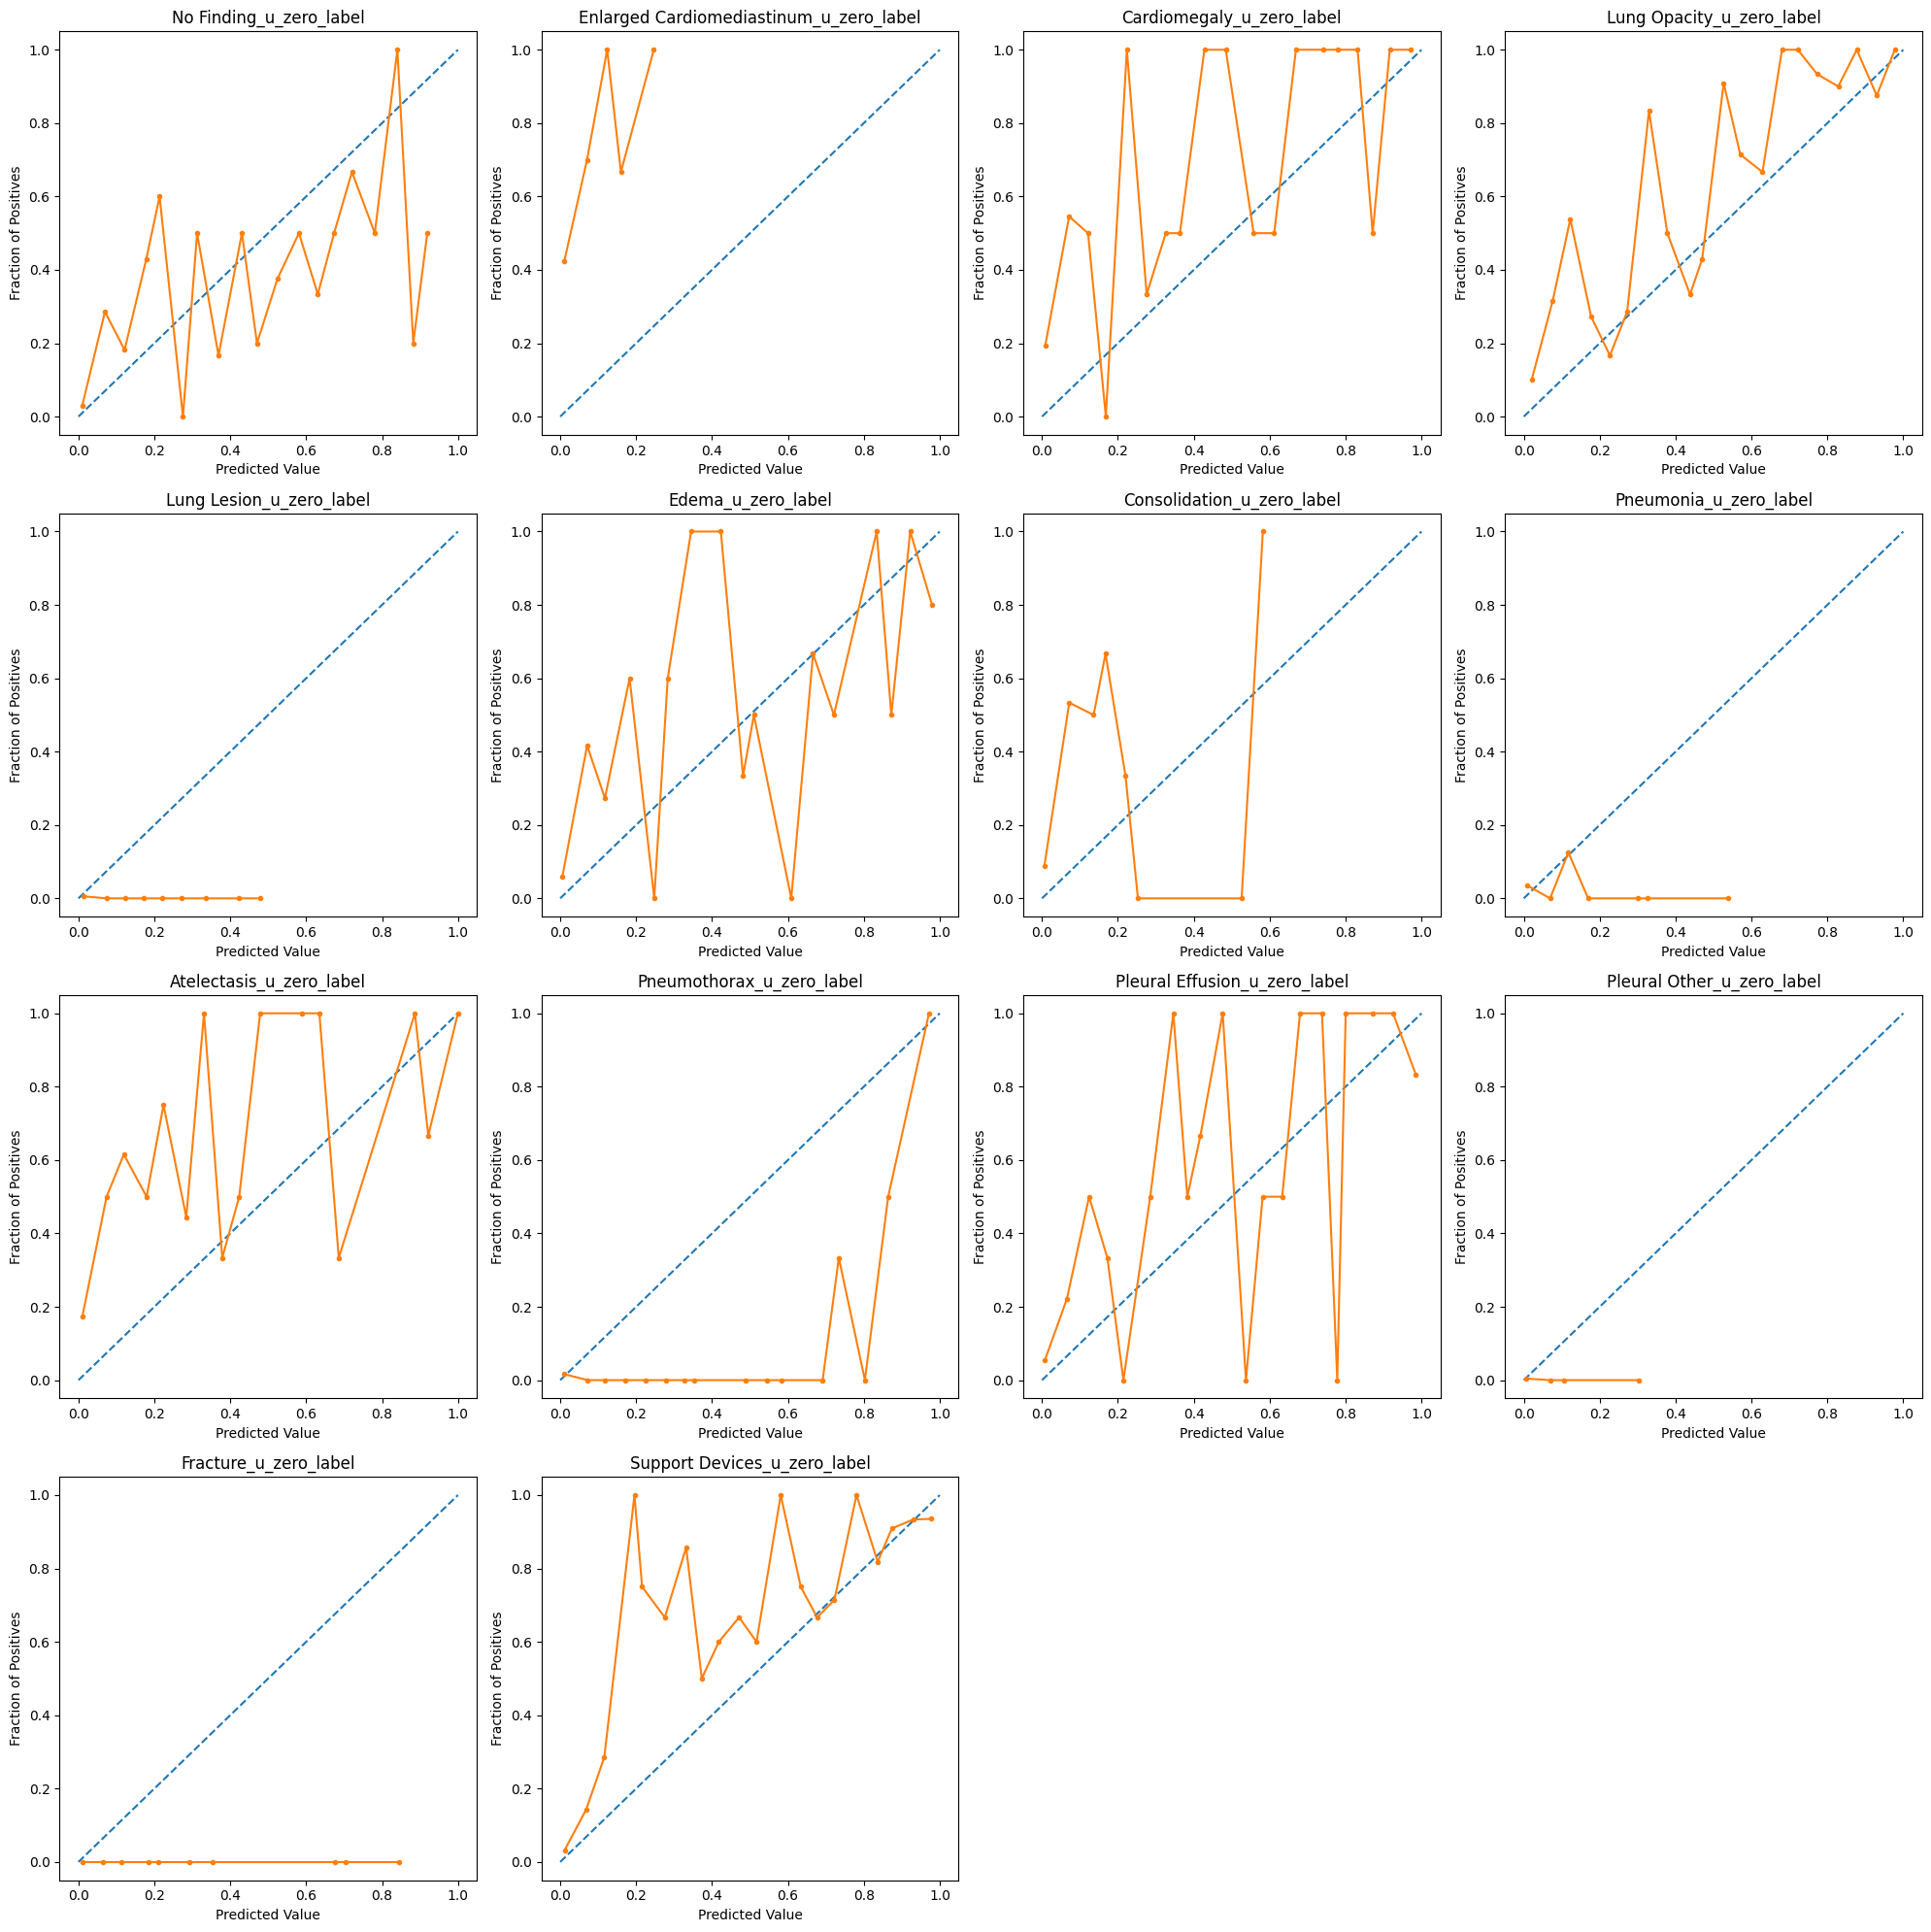

In [51]:
plot_calibration_curve(y, pred, target_columns)

In [52]:
model_performance_df = get_performance_metrics(y, pred, target_columns, acc=get_accuracy, prevalence=get_prevalence, 
                        sens=get_sensitivity, spec=get_specificity, ppv=get_ppv, npv=get_npv, auc=roc_auc_score,f1=f1_score)

Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuous targets
Exception occurred in F1: Classification metrics can't handle a mix of binary and continuou

## Save results to disk

In [53]:
model_performance_df

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
No Finding_u_zero_label,16,175,21,22,0.816,0.162,0.421,0.893,0.432,0.888,0.838,NaN,0.5
Enlarged Cardiomediastinum_u_zero_label,0,125,0,109,0.534,0.466,0.0,1.0,0.0,0.534,0.616,NaN,0.5
Cardiomegaly_u_zero_label,15,163,3,53,0.761,0.291,0.221,0.982,0.833,0.755,0.725,NaN,0.5
Lung Opacity_u_zero_label,88,100,8,38,0.803,0.538,0.698,0.926,0.917,0.725,0.868,NaN,0.5
Lung Lesion_u_zero_label,0,233,0,1,0.996,0.004,0.0,1.0,0.0,0.996,0.348,NaN,0.5
Edema_u_zero_label,15,182,7,30,0.842,0.192,0.333,0.963,0.682,0.858,0.874,NaN,0.5
Consolidation_u_zero_label,2,198,3,31,0.855,0.141,0.061,0.985,0.4,0.865,0.803,NaN,0.5
Pneumonia_u_zero_label,0,225,1,8,0.962,0.034,0.0,0.996,0.0,0.966,0.415,NaN,0.5
Atelectasis_u_zero_label,11,151,3,69,0.692,0.342,0.138,0.981,0.786,0.686,0.813,NaN,0.5
Pneumothorax_u_zero_label,5,218,8,3,0.953,0.034,0.625,0.965,0.385,0.986,0.773,NaN,0.5


In [54]:
model_performance_df.to_csv(f'../model_performance/test_metrics_{MODEL_NAME}.csv')